In [16]:
import os
import pandas as pd
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

from src import config

In [17]:
language = 'german'
folder = os.path.join(config.PROCESSED_DATA_DIR, language)
hist = pd.read_csv(os.path.join(folder, f'hist_polysemy_score_{language}.csv'), sep=';', index_col=0)
contemp = pd.read_csv(os.path.join(folder, f'contemp_polysemy_score_{language}.csv'), sep=';', index_col=0)
conc = pd.read_csv(os.path.join(folder, 'concreteness_ger.csv'), sep=';', index_col='Word')

In [18]:
def get_spearman_corr(df, column, name, conc):
    # create merged dataset
    merged = pd.merge(left=conc, right=df[[column]], left_index=True, right_index=True, how='inner')
    merged.dropna(inplace=True)
    
    # get spearman correlation
    correlation, p_value = spearmanr(merged['concreteness'], merged[column])
    
    # print results
    print(f'Concreteness and {name}')
    print(f'Spearman Correlation Coefficient: {correlation:.4f}')
    print(f'P-value: {p_value:.4e}')
    
    # plot results and save figure
    g = sns.jointplot(x="concreteness", y=column, data=merged, 
                      kind="scatter", joint_kws={"s": 20, "alpha": 0.2})
    fig_name = f"joinplot_concreteness_{column}.png"
    plt.subplots_adjust(left=0.2)
    plt.savefig(os.path.join(config.FIGURES_DIR, fig_name), bbox_inches='tight')
    plt.show()
    

Concreteness and Polysemy Score Evolution
Spearman Correlation Coefficient: 0.4173
P-value: 3.0188e-245


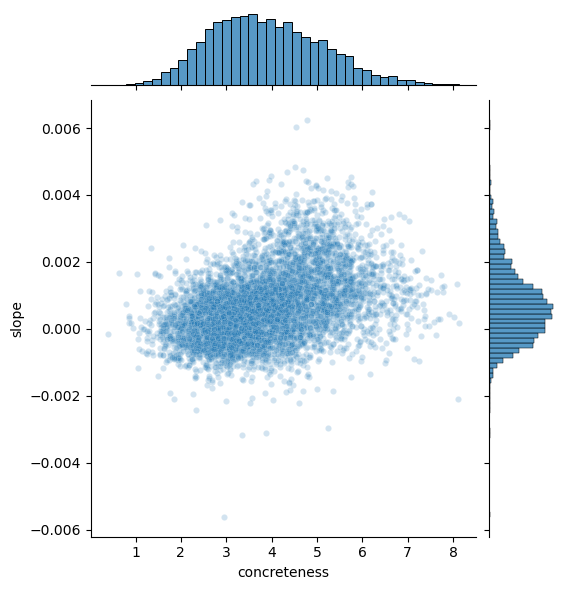

In [19]:
get_spearman_corr(hist, 'slope', 'Polysemy Score Evolution', conc)

Concreteness and Contemporary Polysemy Score
Spearman Correlation Coefficient: 0.0627
P-value: 2.6267e-12


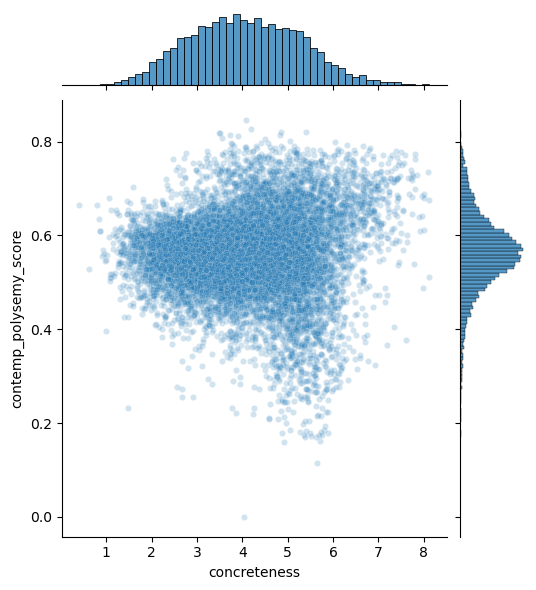

In [20]:
get_spearman_corr(contemp, 'contemp_polysemy_score', 'Contemporary Polysemy Score', conc)

Concreteness and Historic Polysemy Score 1990s
Spearman Correlation Coefficient: -0.0522
P-value: 6.9536e-08


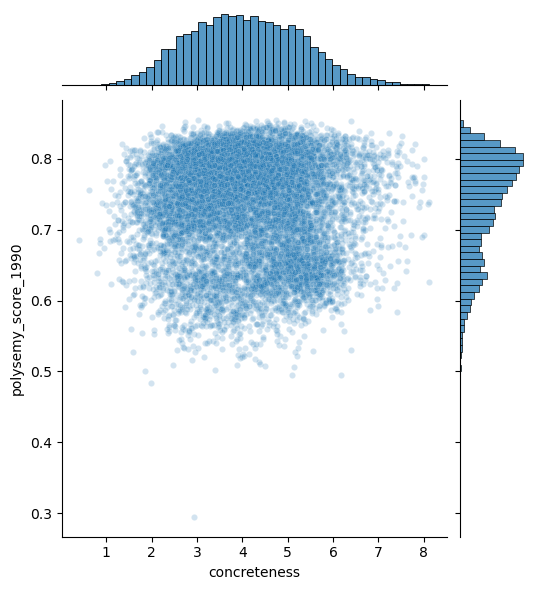

In [21]:
get_spearman_corr(hist, 'polysemy_score_1990', 'Historic Polysemy Score 1990s', conc)

# French

In [22]:
language = 'french'
folder = os.path.join(config.PROCESSED_DATA_DIR, language)
hist = pd.read_csv(os.path.join(folder, f'hist_polysemy_score_{language}.csv'), sep=';', index_col=0)
contemp = pd.read_csv(os.path.join(folder, f'contemp_polysemy_score_{language}.csv'), sep=';', index_col=0)
conc = pd.read_csv(os.path.join(folder, 'concreteness_fre.csv'), sep=';', index_col=0)

Concreteness and Polysemy Score Evolution French
Spearman Correlation Coefficient: -0.0971
P-value: 1.0358e-03


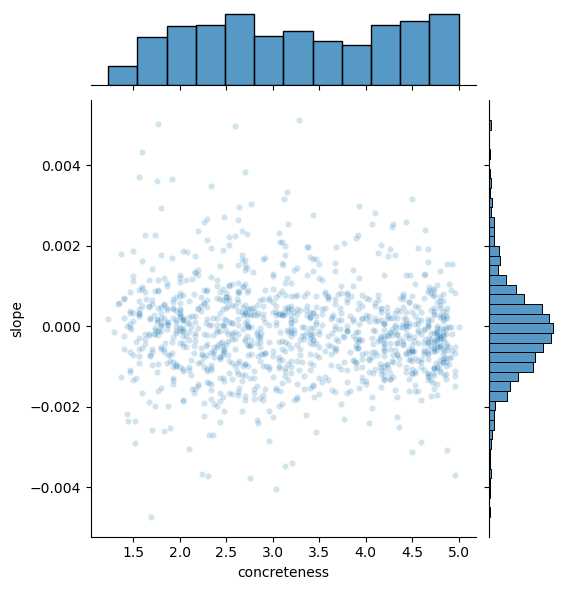

In [23]:
get_spearman_corr(hist, 'slope', 'Polysemy Score Evolution French', conc)

Concreteness and Historic Polysemy Score French 1990s
Spearman Correlation Coefficient: -0.5156
P-value: 1.6392e-87


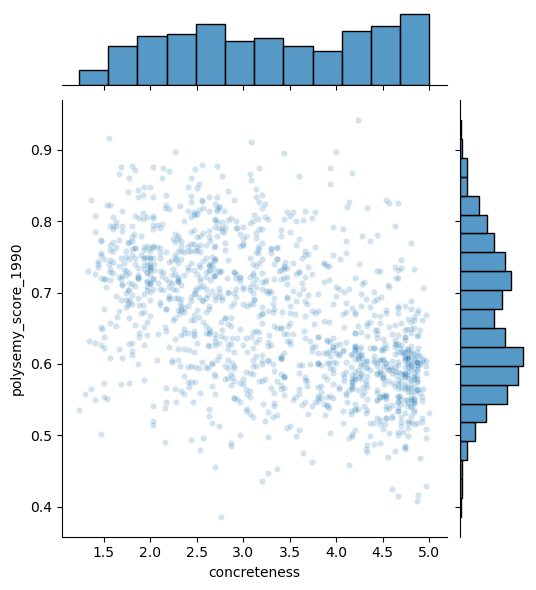

In [24]:
get_spearman_corr(hist, 'polysemy_score_1990', 'Historic Polysemy Score French 1990s', conc)

Concreteness and Contemporary Polysemy Score French
Spearman Correlation Coefficient: -0.0865
P-value: 1.9048e-03


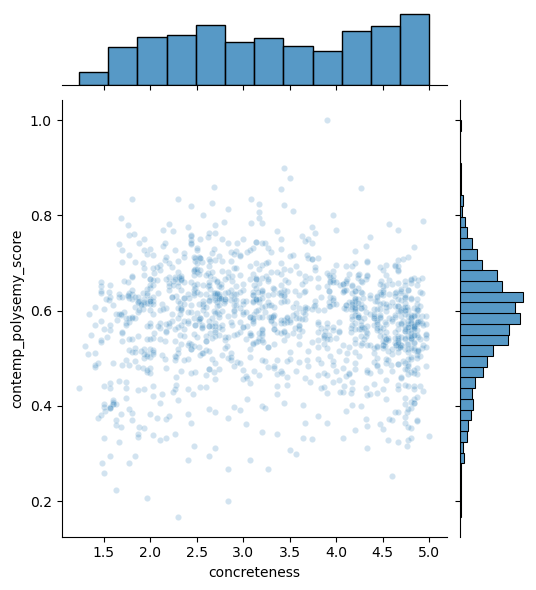

In [25]:
get_spearman_corr(contemp, 'contemp_polysemy_score', 'Contemporary Polysemy Score French', conc)

# English

In [26]:
language = 'english'
folder = os.path.join(config.PROCESSED_DATA_DIR, language)
hist = pd.read_csv(os.path.join(folder, f'hist_polysemy_score_{language}.csv'), sep=';', index_col=0)
contemp = pd.read_csv(os.path.join(folder, f'contemp_polysemy_score_{language}.csv'), sep=';', index_col=0)
conc = pd.read_csv(os.path.join(folder, 'concreteness_eng.csv'), sep=';', index_col='Word')

Concreteness and Polysemy Score Evolution
Spearman Correlation Coefficient: -0.0959
P-value: 1.1889e-18


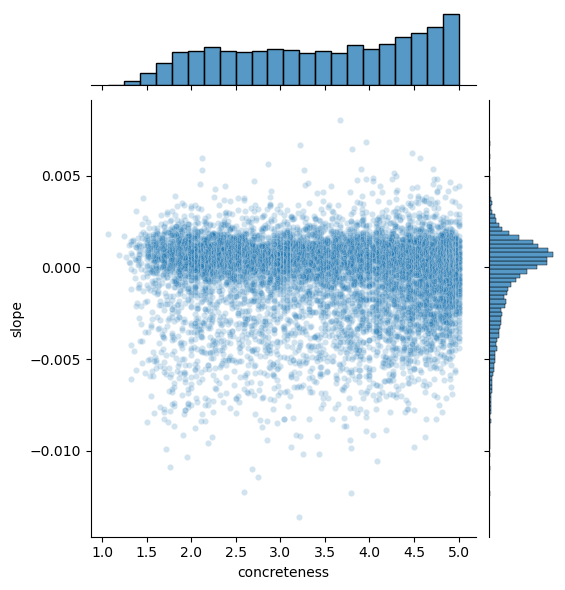

In [27]:
get_spearman_corr(hist, 'slope', 'Polysemy Score Evolution', conc)

Concreteness and Contemporary Polysemy Score English
Spearman Correlation Coefficient: 0.4079
P-value: 0.0000e+00


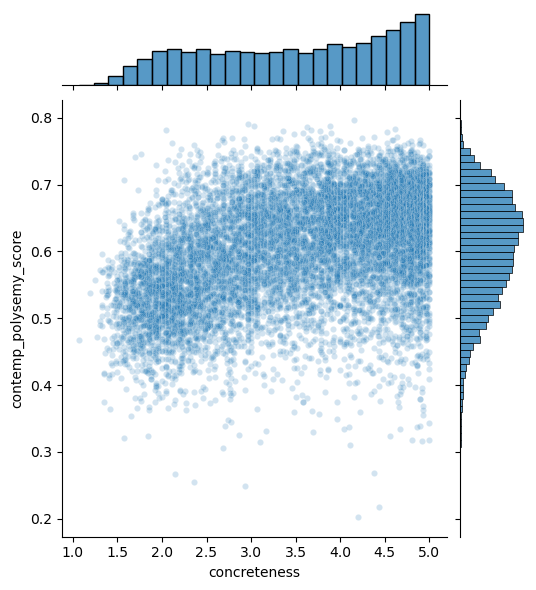

In [28]:
get_spearman_corr(contemp, 'contemp_polysemy_score', 'Contemporary Polysemy Score English', conc)

Concreteness and Historic Polysemy Score English 1990s
Spearman Correlation Coefficient: -0.3281
P-value: 3.3341e-264


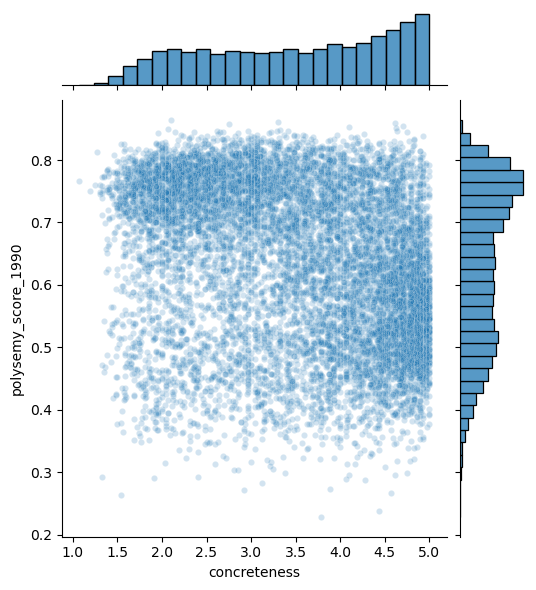

In [29]:
get_spearman_corr(hist, 'polysemy_score_1990', 'Historic Polysemy Score English 1990s', conc)